**Rules for the code:**

- Include all the code you used for your report in this file. The code for any section in the report should go under the same section in this file.
- Any missing code will result in -20% from its corresponding section in the report.
- Any irrelevant code will result in -20% from its corresponding section in the report.
- Make sure that you run your code before rendering, so all the necessary visual/numeric outputs are visible.
- Any code that is not properly run or throws errors will be considered missing/irrelevant.

## 3) Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('uber_data.csv')
data.rename(columns={'Cancelled Rides by Driver': 'Driver Cancelled', 
                     'Cancelled Rides by Customer': 'Customer Cancelled',
                     'Reason for cancelling by Customer': 'Customer Cancellation Reason'}, inplace=True)

data['Time'] = pd.to_datetime(data['Time'])
data['Date'] = pd.to_datetime(data['Date'])

## 5) Data Cleaning 

### a) Cleaning - Question 1
###### 1. What factors most strongly influence ride cancellations (by both customers and drivers)? - Compare the correlations of Booking Status, and Cancelled Rides by both Drivers and Customers. This will include bar charts and heatmaps

In [521]:
ride_cancel_data = data.copy()
# get all data related to incomplete rides and cancellations
ride_cancel_data.drop(columns = ['Booking ID', 'Customer ID', 'Pickup Location', 'Drop Location', 'Avg VTAT', 'Avg CTAT', 'Payment Method'], inplace=True)

# Is there a reason for EVERY cancellation? Yes
ride_cancel_data['Customer Cancellation Reason'].value_counts().sum() == ride_cancel_data['Customer Cancelled'].sum() 
ride_cancel_data['Driver Cancellation Reason'].value_counts().sum() == ride_cancel_data['Driver Cancelled'].sum() 
# Since above is true for both, there is always a reason for customer and driver cancellations

np.True_

In [522]:
# Remove Bike type rides since they cannot be cancelled
ride_cancel_data = ride_cancel_data[ride_cancel_data['Vehicle Type'].isin(['Uber XL', 'Auto', 'Go Sedan', 'Go Mini', 'Premier Sedan'])]

ride_cancel_old_count_c = ride_cancel_data['Customer Cancellation Reason'].value_counts()
ride_cancel_old_count_d = ride_cancel_data['Driver Cancellation Reason'].value_counts()
# If the customer cancellation reason is 'Driver asked to cancel', then the driver actually cancelled the ride. We need to fix this.
def fix_cancelled(row):
    if row['Customer Cancellation Reason'] == 'Driver asked to cancel':
        row['Booking Status'] = 'Cancelled by Driver'
        row['Driver Cancellation Reason'] = row['Customer Cancellation Reason']
        row['Customer Cancellation Reason'] = np.nan
        row['Customer Cancelled'] = 0
        row['Driver Cancelled'] = 1
        
    if row['Driver Cancellation Reason'] == 'The customer was coughing/sick':
        row['Booking Status'] = 'Cancelled by Customer'
        row['Customer Cancellation Reason'] = 'Sick or Health Issue'
        row['Customer Cancelled'] = 1
        row['Driver Cancellation Reason'] = np.nan
        row['Driver Cancelled'] = 0
    return row

ride_cancel_data = ride_cancel_data.apply(fix_cancelled, axis=1)

ride_cancel_data['Customer Cancellation Reason'] = ride_cancel_data['Customer Cancellation Reason'].map({
    'Driver is not moving towards pickup location': 'Driver not moving to pickup',
    'AC is not working': 'AC not working',
    'Change of plans': 'Change of plans',
    'Wrong Address': 'Wrong Address',
    'Sick or Health Issue': 'Sick or Health Issue',
    })

print("Customer Reasons:", ride_cancel_data['Customer Cancellation Reason'].unique())
print("Driver Reasons:", ride_cancel_data['Driver Cancellation Reason'].unique())
print("Num Driver Cancelled:", ride_cancel_data['Driver Cancelled'].sum())
print("Num Customer Cancelled:", ride_cancel_data['Customer Cancelled'].sum())
print("Total Rides:", len(ride_cancel_data))

Customer Reasons: [nan 'Driver not moving to pickup' 'AC not working' 'Change of plans'
 'Sick or Health Issue' 'Wrong Address']
Driver Reasons: [nan 'Customer related issue' 'Personal & Car related issues'
 'More than permitted people in there' 'Driver asked to cancel']
Num Driver Cancelled: 17508.0
Num Customer Cancelled: 11710.0
Total Rides: 116926


### b) Cleaning - Question 2

Which variables correlate most strongly with customer ratings?

In [523]:
duration_data = data.copy()
duration_data.rename(columns={'Avg CTAT': 'Ride Duration', 'Avg VTAT': 'Pickup Duration'}, inplace=True)
duration_data = duration_data[['Date', 'Time', 'Vehicle Type', 'Pickup Duration', 'Ride Duration', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']]
duration_data = duration_data[duration_data['Customer Rating'].notnull()]
duration_data_OH = pd.get_dummies(duration_data, columns=['Vehicle Type'])

## 6) Data Analysis

### a) Analysis 1

In [524]:
# comparing cancellation reason counts before and after cleaning
print(ride_cancel_old_count_c)
print(ride_cancel_old_count_d)
print(ride_cancel_data['Customer Cancellation Reason'].value_counts())
print(ride_cancel_data['Driver Cancellation Reason'].value_counts())

Customer Cancellation Reason
Change of plans                                 1783
Wrong Address                                   1775
Driver is not moving towards pickup location    1765
Driver asked to cancel                          1724
AC is not working                               1155
Name: count, dtype: int64
Driver Cancellation Reason
Customer related issue                 5335
Personal & Car related issues          5232
The customer was coughing/sick         5232
More than permitted people in there    5217
Name: count, dtype: int64
Customer Cancellation Reason
Sick or Health Issue           5232
Change of plans                1783
Wrong Address                  1775
Driver not moving to pickup    1765
AC not working                 1155
Name: count, dtype: int64
Driver Cancellation Reason
Customer related issue                 5335
Personal & Car related issues          5232
More than permitted people in there    5217
Driver asked to cancel                 1724
Name: count, 

In [525]:
# comparing proportions of cancellations before and after cleaning
customer_cancel_counts_old = data['Customer Cancellation Reason'].value_counts()
driver_cancel_counts_old = data['Driver Cancellation Reason'].value_counts()
customer_cancel_counts = ride_cancel_data['Customer Cancellation Reason'].value_counts()
driver_cancel_counts = ride_cancel_data['Driver Cancellation Reason'].value_counts()
print("Proportion of rides cancelled by customers:", customer_cancel_counts_old.sum()/data.shape[0])
print("Proportion of rides cancelled by drivers:", driver_cancel_counts_old.sum()/data.shape[0])  
print("Proportion of rides cancelled by customers:", customer_cancel_counts.sum()/ride_cancel_data.shape[0])
print("Proportion of rides cancelled by drivers:", driver_cancel_counts.sum()/ride_cancel_data.shape[0])  

Proportion of rides cancelled by customers: 0.07
Proportion of rides cancelled by drivers: 0.18
Proportion of rides cancelled by customers: 0.10014881206917195
Proportion of rides cancelled by drivers: 0.14973573029095325


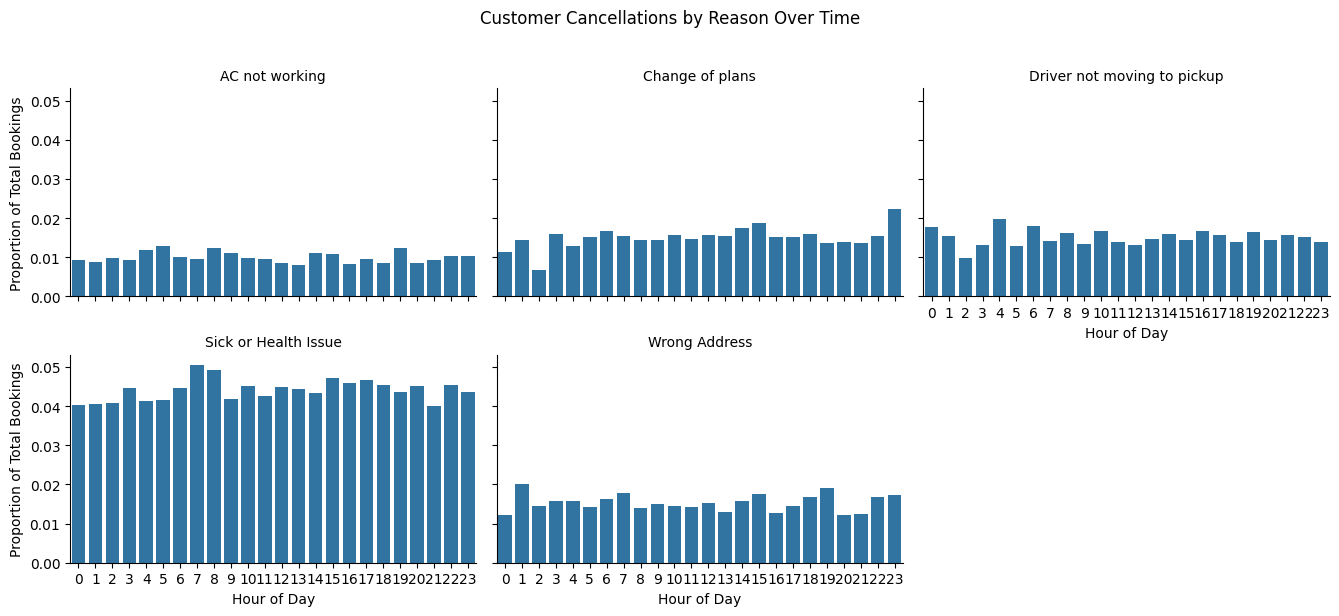

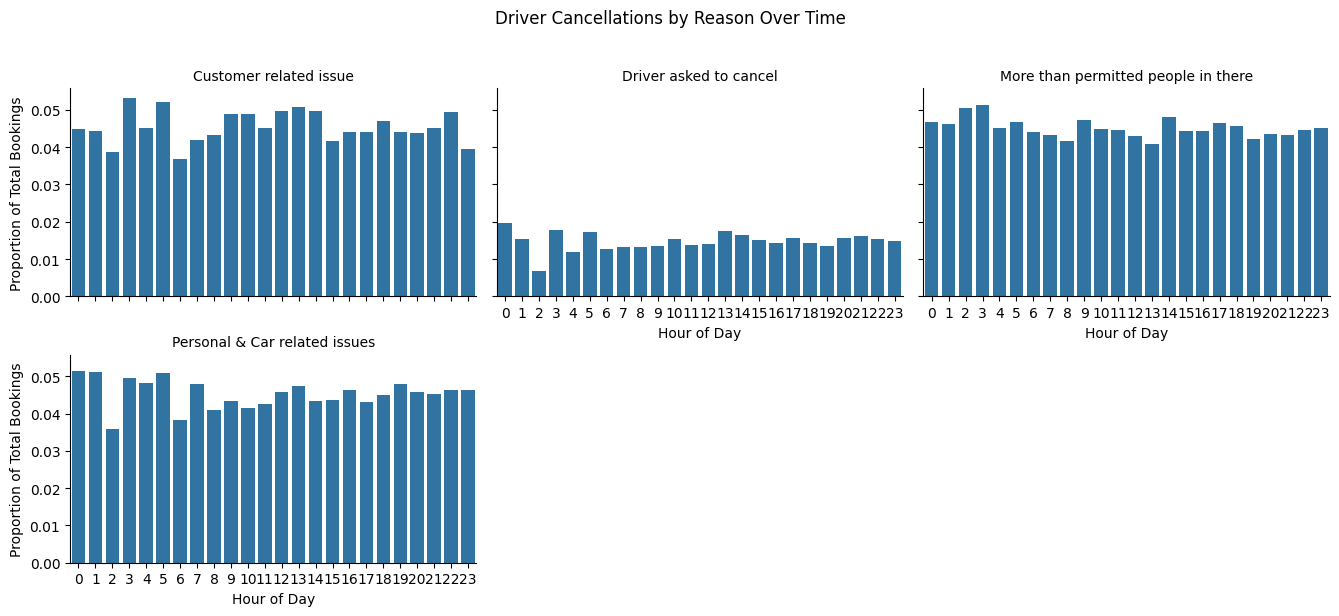

In [ ]:
# Get hour from time
ride_cancel_data['Hour'] = ride_cancel_data['Time'].dt.hour

def plot_cancellations(data, cancel_by, reason_col, title):
    total_per_hour = data.groupby('Hour').size()
    cancels_hour_reason = data[data[cancel_by] == 1].groupby(['Hour', reason_col]).size().unstack()

    proportion_hour_reason = cancels_hour_reason.div(total_per_hour, axis=0)

    # wide to long format
    long_df = (proportion_hour_reason.reset_index().melt(id_vars='Hour', var_name='Cancellation Reason',value_name='Proportion'))
    
    # plot
    g = sns.FacetGrid(
        long_df,
        col="Cancellation Reason",
        col_wrap=3,
        height=3,
        aspect=1.5,
        
    )

    g.map(sns.barplot, "Hour", "Proportion")
    g.set_titles("{col_name}")
    g.set_axis_labels("Hour of Day", "Proportion of Total Bookings")
    g.fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

plot_cancellations(ride_cancel_data, 'Customer Cancelled', 'Customer Cancellation Reason', 'Customer Cancellations by Reason Over Time')
plot_cancellations(ride_cancel_data, 'Driver Cancelled', 'Driver Cancellation Reason', 'Driver Cancellations by Reason Over Time')

### b) Analysis 2

In [527]:
duration_data_OH.corrwith(duration_data_OH['Customer Rating']).sort_values(ascending=False)

Customer Rating               1.000000
Vehicle Type_Go Sedan         0.005779
Ride Distance                 0.004514
Ride Duration                 0.001000
Vehicle Type_Uber XL          0.000107
Booking Value                -0.000287
Vehicle Type_Go Mini         -0.000327
Vehicle Type_eBike           -0.000396
Vehicle Type_Bike            -0.000620
Vehicle Type_Premier Sedan   -0.000955
Driver Ratings               -0.001010
Time                         -0.002283
Date                         -0.002467
Vehicle Type_Auto            -0.003399
Pickup Duration              -0.003945
dtype: float64

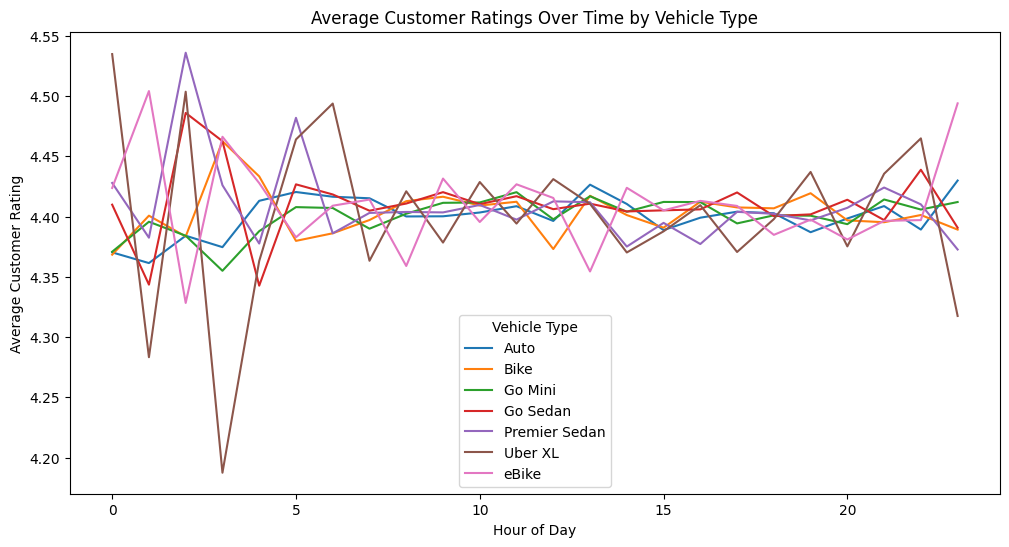

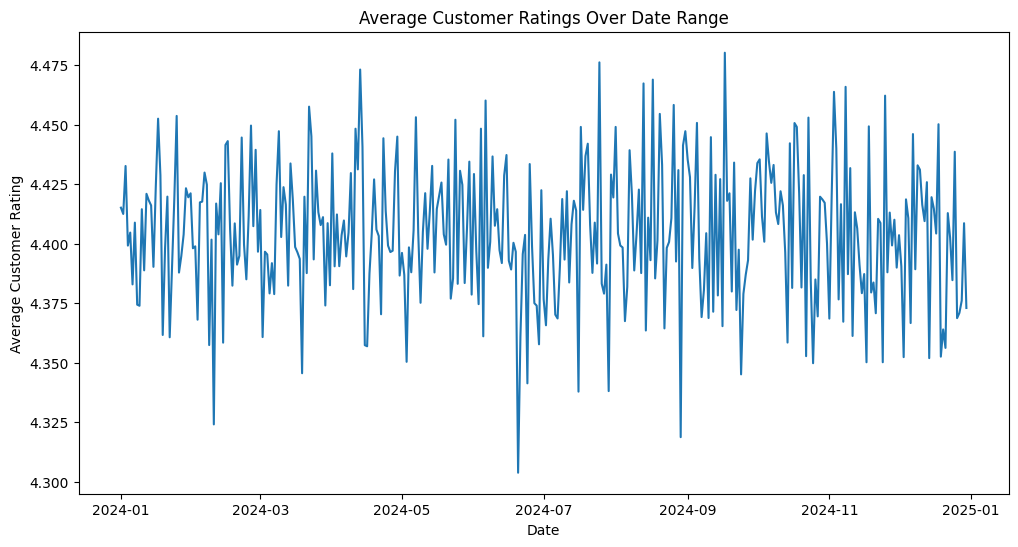

In [ ]:
# customer ratings over time
customer_ratings_over_time = duration_data.copy()
customer_ratings_over_time['Hour'] = customer_ratings_over_time['Time'].dt.hour
customer_ratings_over_time = customer_ratings_over_time.groupby(['Hour', 'Vehicle Type'])['Customer Rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=customer_ratings_over_time, x='Hour', y='Customer Rating', hue='Vehicle Type')
plt.title('Average Customer Ratings Over Time by Vehicle Type')
plt.xlabel('Hour of Day')
plt.ylabel('Average Customer Rating')
plt.legend(title='Vehicle Type')
plt.show()

# over date range
customer_ratings_date = duration_data.copy()
customer_ratings_date = customer_ratings_date.groupby('Date')['Customer Rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=customer_ratings_date, x='Date', y='Customer Rating')
plt.title('Average Customer Ratings Over Date Range')
plt.xlabel('Date')
plt.ylabel('Average Customer Rating')
plt.show()

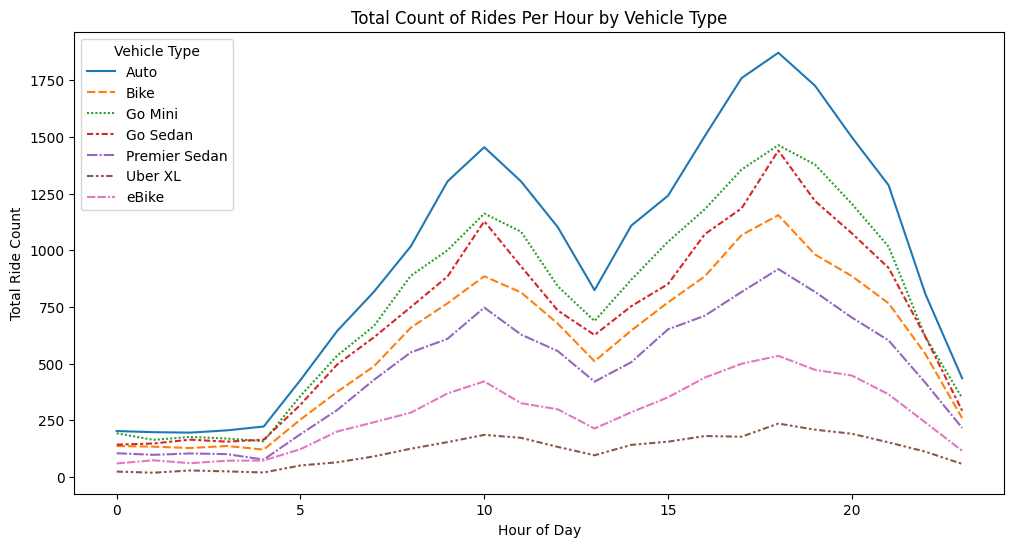

In [529]:
# total count of rides per hour by vehicle type
ride_counts = duration_data.groupby([duration_data['Time'].dt.hour, 'Vehicle Type']).size().reset_index(name='Ride Count')
ride_counts_pivot = ride_counts.pivot(index='Time', columns='Vehicle Type', values='Ride Count')
plt.figure(figsize=(12, 6))
sns.lineplot(data=ride_counts_pivot)
plt.title('Total Count of Rides Per Hour by Vehicle Type')
plt.xlabel('Hour of Day')
plt.ylabel('Total Ride Count')
plt.legend(title='Vehicle Type')
plt.show()